In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx

import esda  
from libpysal import weights

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch, Rectangle, Circle
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.lines import Line2D

## House keeping
First define all projections that I will be using. This includes WebMercator for mapping onto contextily basemaps. Then load in the data. I have included two datasets here so far. They are:
- A shapefile of census tracts from 2010 used for the Cal Enviro Screen 4.0 analysis
- A csv that is one sheet taken from the Excel spreadsheet available for download from the Cal enviro screen website. This is the sheet titled "CES4.0FINAL_results" and is labeled `factors` in this code.

All data was downloaded from the [CalEnviroScreen4.0 report website](https://oehha.ca.gov/calenviroscreen/report/calenviroscreen-40)

In [2]:
WEBMERC = 3857 #the projected coordinate system for web mapping (adding basemaps with Contextily)

In [3]:
zipfile = "zip:///Users/vlingenfelter5/Documents/spring2022/cj/calenviroscreen40shpf2021shp.zip"
ces_gdf = gpd.read_file(zipfile)

In [4]:
factors = pd.read_csv('./cal_enviro_screen_4.csv')

## Clean up the data (a little bit)
Because some of the column names contained spaces or non-alphanumeric characters, I went ahead and renamed them to things that were underscore separated and a little shorter

This is partly to avoid having to use spaces (for me) and also in case anyone wants to open my files later in ArcGIS

In [5]:
column_name_map = {
    'Census Tract': 'Tract',
    'Total Population': 'total_pop',
    'California County': 'county',
    'Approximate Location': 'approx_loc',
    'Longitude': 'lon',
    'Latitude': 'lat',
    'CES 4.0 Score': 'ces_score',
    ' CES 4.0 Percentile': 'ces_pctl',
    'CES 4.0 Percentile Range': 'ces_pctl_range',
    'Ozone': 'ozone',
    'Ozone Pctl': 'ozone_pctl',
    'PM2.5': 'pm25',
    'PM2.5 Pctl': 'pm25_pctl',
    'Diesel PM': 'diesel_pm',
    'Diesel PM Pctl': 'diesel_pm_pctl',
    'Drinking Water': 'drinking_water',
    'Drinking Water Pctl': 'drinking_water_pctl',
    'Lead': 'lead',
    'Lead Pctl': 'lead_pctl',
    'Pesticides': 'pesticides',
    'Pesticides Pctl': 'pesticides_pctl',
    'Tox. Release': 'tox_release',
    'Tox. Release Pctl': 'tox_release_pctl',
    'Traffic': 'traffic',
    'Traffic Pctl': 'traffic_pctl',
    'Cleanup Sites': 'cleanup_sites',
    'Cleanup Sites Pctl': 'cleanup_sites_pctl',
    'Groundwater Threats': 'groundwater',
    'Groundwater Threats Pctl': 'groundwater_pctl',
    'Haz. Waste': 'haz_waste',
    'Haz. Waste Pctl': 'haz_waste_pctl',
    'Imp. Water Bodies': 'imp_water_bodies',
    'Imp. Water Bodies Pctl': 'imp_water_bodies_pctl',
    'Solid Waste': 'solid_waste',
    'Solid Waste Pctl': 'solid_waste_pctl',
    'Pollution Burden': 'poll_burden',
    'Pollution Burden Score': 'poll_burden_score',
    'Pollution Burden Pctl': 'poll_burden_pctl',
    'Asthma': 'asthma',
    'Asthma Pctl': 'asthma_pctl',
    'Low Birth Weight': 'lbw',
    'Low Birth Weight Pctl': 'lbw_pctl',
    'Cardiovascular Disease': 'cardio',
    'Cardiovascular Disease Pctl': 'cardio_pctl',
    'Education': 'edu',
    'Education Pctl': 'edu_pctl',
    'Linguistic Isolation': 'ling',
    'Linguistic Isolation Pctl': 'ling_pctl',
    'Poverty': 'poverty',
    'Poverty Pctl': 'poverty_pctl',
    'Unemployment': 'unemp',
    'Unemployment Pctl': 'unemp_pctl',
    'Housing Burden': 'housing_burden',
    'Housing Burden Pctl': 'housing_burden_pctl',
    'Pop. Char. ': 'pop_char',
    'Pop. Char. Score': 'pop_char_score',
    'Pop. Char. Pctl': 'pop_char_pctl'
}

In [6]:
columns_readable_map = {v: k for k, v in column_name_map.items()}

In [7]:
factors.rename(columns=column_name_map, inplace=True)

## Recreating the correlation matrix

In the paper that did sensitivity analysis, they recorded pearson's correlation coefficients for each variable that was used in the index. I have recreated that here using the new index factors. 

In the final figure, correlation coefficients that are greater than 0.6 are highlighted with black boxes. This excludes the self relationship. 

In [8]:
factors_corr_matrix_columns = [
    'ozone',
    'pm25',
    'diesel_pm',
    'drinking_water',
    'lead',
    'pesticides',
    'tox_release',
    'traffic',
    'cleanup_sites',
    'groundwater',
    'haz_waste',
    'imp_water_bodies',
    'solid_waste',
    'asthma',
    'lbw',
    'cardio',
    'edu',
    'ling',
    'poverty',
    'unemp',
    'housing_burden'
]

factors_corr_matrix = factors[factors_corr_matrix_columns]
corr = factors_corr_matrix.corr()

In [9]:
sig_locs = []
for i, col in enumerate(factors_corr_matrix_columns):
    sig_cols = corr[((corr[col] >= 0.6) & (corr[col] < 1)) |
                    ((corr[col] <= -0.6) & (corr[col] > -1))
                   ].index.tolist()
    
    if len(sig_cols)>0:
        for sig_col in sig_cols:
            sig_locs.append(((i+0.5), (factors_corr_matrix_columns.index(sig_col)+0.5)))

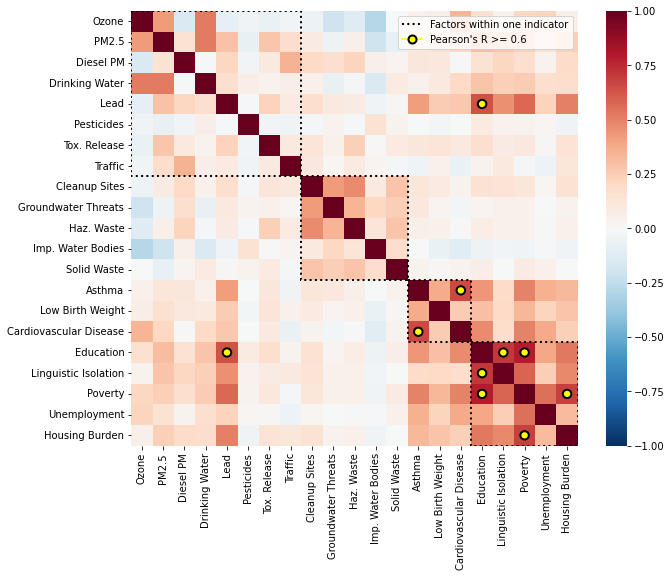

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr, cmap='RdBu_r', vmin=-1, vmax=1,
            xticklabels=[columns_readable_map[c] for c in corr.columns],
            yticklabels=[columns_readable_map[c] for c in corr.columns])

# add boxes around all the R values that are greater than 0.6 (by abs value)
for s in sig_locs:    
    # ax.add_patch(Rectangle(s, 1, 1, fill=False, edgecolor='k', lw=2))
    ax.add_patch(Circle(s, 0.2, facecolor='yellow', edgecolor='k', lw=2))

# add dashed lines around the different indicator groups
ax.add_patch(Rectangle((0,0), 8, 8, fill=False, edgecolor='k', lw=2, linestyle='dotted'))
ax.add_patch(Rectangle((8,8), 5, 5, fill=False, edgecolor='k', lw=2, linestyle='dotted'))
ax.add_patch(Rectangle((13,13), 3, 3, fill=False, edgecolor='k', lw=2, linestyle='dotted'))
ax.add_patch(Rectangle((16,16), 5, 5, fill=False, edgecolor='k', lw=2, linestyle='dotted'))

legend_elements = [
    Line2D([0], [0], color='k', lw=2, linestyle='dotted', 
           label='Factors within one indicator'),
    Line2D([0], [0], marker='o', color='yellow', label="Pearson's R >= 0.6",
           markerfacecolor='yellow', markeredgecolor='k', 
           markeredgewidth=2, markersize=8),
]

ax.legend(handles=legend_elements,loc='upper right')

## Remaking the indicators

In [11]:
environmental_effects = [
    'ozone_pctl', 
    'pm25_pctl', 
    'diesel_pm_pctl',
    'drinking_water_pctl',
    'lead_pctl',
    'pesticides_pctl',
    'tox_release_pctl',
    'traffic_pctl'
]
environmental_exposures = [
    'cleanup_sites_pctl', 
    'groundwater_pctl', 
    'haz_waste_pctl',
    'imp_water_bodies_pctl',
    'solid_waste_pctl',
]
socioeconomic_factors = [
    'edu_pctl',
    'ling_pctl',
    'poverty_pctl',
    'unemp_pctl',
    'housing_burden_pctl'
]
sensitive_populations = [
    'asthma_pctl',
    'lbw_pctl',
    'cardio_pctl'
]

factors['env_eff'] = factors[environmental_effects].mean(axis=1)
factors['env_exp'] = factors[environmental_exposures].mean(axis=1)
factors['socio'] = factors[socioeconomic_factors].mean(axis=1)
factors['sens_pop'] = factors[sensitive_populations].mean(axis=1)

In [12]:
factors['eq_poll_burden'] = factors[['env_exp', 'env_eff']].mean(axis=1)

In [13]:
def delta_scaling(col):
    col_max = col.max()
    return 10/col_max * col

In [14]:
factors['eq_poll_burden_score'] = delta_scaling(factors['eq_poll_burden'])

In [15]:
factors['eq_poll_burden_ces_score'] = factors['eq_poll_burden_score'] * factors['pop_char_score']

<AxesSubplot:xlabel='ces_score', ylabel='eq_poll_burden_ces_score'>

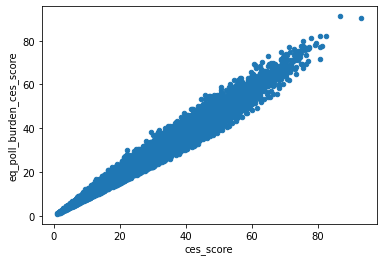

In [16]:
factors.plot.scatter(x='ces_score', y='eq_poll_burden_ces_score')

In [17]:
factors['eq_poll_burden_score_diff'] = factors['ces_score'] - factors['eq_poll_burden_ces_score']

In [18]:
pollution_burden_factors = environmental_exposures + environmental_effects

In [19]:
pop_char_factors = [
    'asthma_pctl',
    'lbw_pctl',
    'cardio_pctl',
    'edu_pctl',
    'ling_pctl',
    'poverty_pctl',
    'unemp_pctl',
    'housing_burden_pctl'
]

In [20]:
factors['all_poll_burden'] = factors[pollution_burden_factors].mean(axis=1)
factors['all_pop_char'] = factors[pop_char_factors].mean(axis=1)

factors['all_poll_burden_scale'] = delta_scaling(factors['all_poll_burden'])
factors['all_pop_char_scale'] = delta_scaling(factors['all_pop_char'])

factors['all_ces_score'] = factors['all_poll_burden_scale'] * factors['all_pop_char_scale']

<AxesSubplot:xlabel='ces_score', ylabel='all_ces_score'>

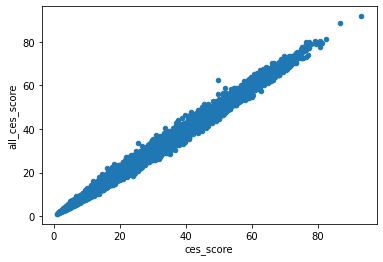

In [21]:
factors.plot.scatter(x='ces_score', y='all_ces_score')

In [22]:
ces_gdf = ces_gdf[['Tract','geometry']]
ces_gdf['Tract'] = ces_gdf['Tract'].astype(int)

In [23]:
gdf = ces_gdf.merge(factors, on='Tract', how='inner')

In [24]:
# gdf['burden_only'] = gdf['env_exp'] + gdf['env_eff'] + gdf['sens_pop']

In [25]:
gdf['eq_poll_burden_ces_score_pctl'] = gdf['eq_poll_burden_ces_score'].rank(pct=True) * 100
gdf['eq_poll_burden_ces_score_rank'] = gdf['eq_poll_burden_ces_score'].rank(method='first')
gdf['eq_pctl_diff'] = gdf['ces_pctl'] - gdf['eq_poll_burden_ces_score_pctl']

gdf['all_ces_score_pctl'] = gdf['all_ces_score'].rank(pct=True) * 100
gdf['all_ces_score_rank'] = gdf['all_ces_score'].rank(method='first')
gdf['all_pctl_diff'] = gdf['ces_pctl'] - gdf['all_ces_score_pctl']

gdf['ces_score_rank'] = gdf['ces_score'].rank(method='first')

In [26]:
gdf['all_ces_score_rank_change'] = (gdf['ces_score_rank'] - gdf['all_ces_score_rank']).abs()
gdf['eq_poll_burden_ces_score_rank_change'] = (gdf['ces_score_rank'] - gdf['eq_poll_burden_ces_score_rank']).abs()

In [27]:
bins_unit = 50

In [28]:
bins = []

for i in range(0,41):
    bins.append(bins_unit*i)

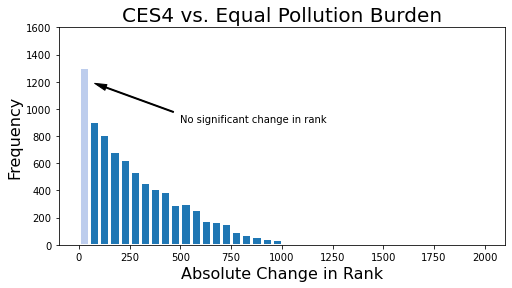

In [59]:
fig, ax = plt.subplots(figsize=(8, 4))
N, bins, patches = ax.hist(gdf['eq_poll_burden_ces_score_rank_change'], bins=bins,
                           edgecolor='white', linewidth=3)

ax.set_ylabel('Frequency', fontsize=16)
ax.set_xlabel('Absolute Change in Rank', fontsize=16)
ax.set_title('CES4 vs. Equal Pollution Burden', fontsize=20)

ax.set_ylim(0,1600)

ax.annotate('No significant change in rank',
            xy=(55, 1200), xycoords='data',
            xytext=(0.6, 0.6), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6),
            horizontalalignment='right', verticalalignment='top')

patches[0].set_facecolor('#bdcded')
plt.show()

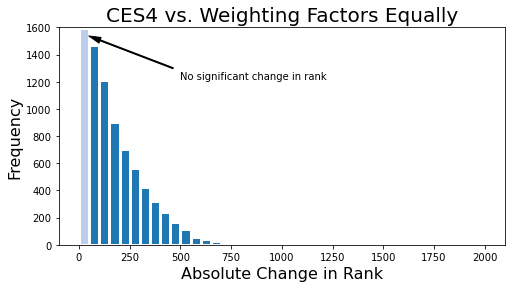

In [62]:
fig, ax = plt.subplots(figsize=(8, 4))
# gdf['all_ces_score_rank_change'].hist(ax=ax, bins=200, grid=False)
N, bins, patches = ax.hist(gdf['all_ces_score_rank_change'], bins=bins,
                           edgecolor='white', linewidth=3)

ax.set_ylabel('Frequency', fontsize=16)
ax.set_xlabel('Absolute Change in Rank', fontsize=16)
ax.set_title('CES4 vs. Weighting Factors Equally', fontsize=20)

ax.set_ylim(0,1600)

ax.annotate('No significant change in rank',
            xy=(25, 1550), xycoords='data',
            xytext=(0.6, 0.8), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6),
            horizontalalignment='right', verticalalignment='top')

patches[0].set_facecolor('#bdcded')
plt.show()

In [31]:
ces_worst_tracts = set(gdf[gdf['ces_pctl'] >= 80]['Tract'].tolist())
eq_poll_burden_worst_tracts = set(gdf[gdf['eq_poll_burden_ces_score_pctl'] >= 80]['Tract'].tolist())
all_ces_worst_tracts = set(gdf[gdf['all_ces_score_pctl'] >= 80]['Tract'].tolist())

Let's see how the worst scoring tracts compare with the different methods of calculating the scores.

I calculated:
- the number of tracts that were not in the top 20% after recalcuating scores
- the percentage of the worst tracts that changed with the different score calcuation
- the number of tracts with a significant shift in their rank (a shift greater than 50)

In [32]:
worst_tracts_df = gdf[gdf['Tract'].isin(ces_worst_tracts)]

In [33]:
len(ces_worst_tracts - eq_poll_burden_worst_tracts)

173

In [34]:
len(ces_worst_tracts - eq_poll_burden_worst_tracts)/len(ces_worst_tracts)

0.1090107120352867

In [35]:
len(worst_tracts_df[(worst_tracts_df['ces_score_rank'] - worst_tracts_df['eq_poll_burden_ces_score_rank']).abs()>50])

1221

In [36]:
len(ces_worst_tracts - all_ces_worst_tracts)

86

In [37]:
len(ces_worst_tracts - all_ces_worst_tracts)/len(ces_worst_tracts)

0.05419029615626969

In [38]:
len(worst_tracts_df[(worst_tracts_df['ces_score_rank'] - worst_tracts_df['all_ces_score_rank']).abs()>50])

1223

## Mapping

I chose the same color scale as used in some of the maps in the CalEnviroScreen report. I defined a function that would map all the scores the same way, with the same scale.

In [39]:
cmap = LinearSegmentedColormap.from_list(
    'mycmap', 
    [
        (0, '#d3d3d3'),
        (0.1, '#bbbbbb'), 
        (0.2, '#a6a6a6'),
        (0.3, '#909090'),
        (0.4, '#7F7F7F'),
        (0.5, '#6d6d6d'),
        (0.6, '#5d5d5d'),
        (0.7, '#87cfab'),
        (0.8, '#3ea3b3'),
        (0.9, '#152a70'),
        (1, '#152a70')
    ])

In [40]:
def color_code(p):
    if p < 11:
        return '#d3d3d3'
    elif p < 21:
        return '#bbbbbb'
    elif p < 31:
        return '#a6a6a6'
    elif p < 41:
        return '#909090'
    elif p < 51:
        return '#7F7F7F'
    elif p < 61:
        return '#6d6d6d'
    elif p < 71:
        return '#5d5d5d'
    elif p < 81:
        return '#87cfab'
    elif p < 91:
        return '#3ea3b3'
    else:
        return '#152a70'

In [41]:
legend_elements = [
    Patch(facecolor='#d3d3d3', edgecolor='#6d6d6d', label='0-10'),
    Patch(facecolor='#bbbbbb', edgecolor='#6d6d6d', label='11-20'),
    Patch(facecolor='#a6a6a6', edgecolor='#6d6d6d', label='21-30'),
    Patch(facecolor='#909090', edgecolor='#6d6d6d', label='31-40'),
    Patch(facecolor='#7F7F7F', edgecolor='#6d6d6d', label='41-50'),
    Patch(facecolor='#6d6d6d', edgecolor='#6d6d6d', label='51-60'),
    Patch(facecolor='#5d5d5d', edgecolor='#6d6d6d', label='61-70'),
    Patch(facecolor='#87cfab', edgecolor='#6d6d6d', label='71-80 (Top 30%)'),
    Patch(facecolor='#3ea3b3', edgecolor='#6d6d6d', label='81-90 (Top 20%)'),
    Patch(facecolor='#152a70', edgecolor='#6d6d6d', label='91-100 (Top 10%)'),
]

def make_map(gdf, col, path='', title=''):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax = gdf.to_crs(epsg=WEBMERC).plot(ax=ax, 
                                       color=[color_code(v) for v in gdf[col]], 
                                       legend=True)

    ax.text(x=-13800000-28000, y=4050000, s='N', fontsize=30)
    ax.arrow(-13800000, 3900000, 0, 200, length_includes_head=True,
              head_width=40000, head_length=500, overhang=250, facecolor='k')
    ax.add_artist(ScaleBar(location='lower left', box_alpha=0, dx=1, pad=1.1))
    ax.legend(handles=legend_elements,
              title='Score Percentile',
              loc='upper right',
              fancybox=True, 
              prop={'size': 14})
    ax.set_title(title, fontsize=20)
    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
    ax.axis('off')
    
    if (len(path) > 0):
        plt.savefig(path)
        
    plt.show()

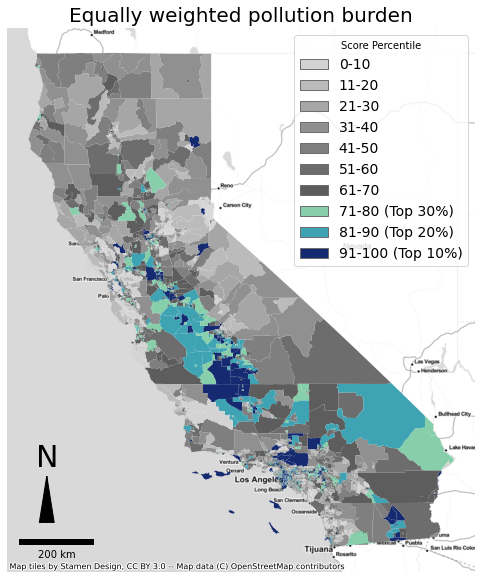

In [42]:
make_map(gdf, 'eq_poll_burden_ces_score_pctl', title='Equally weighted pollution burden')

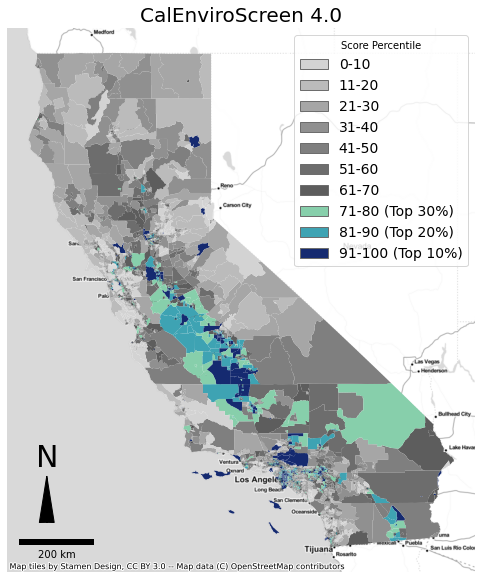

In [43]:
make_map(gdf, 'ces_pctl', title='CalEnviroScreen 4.0')

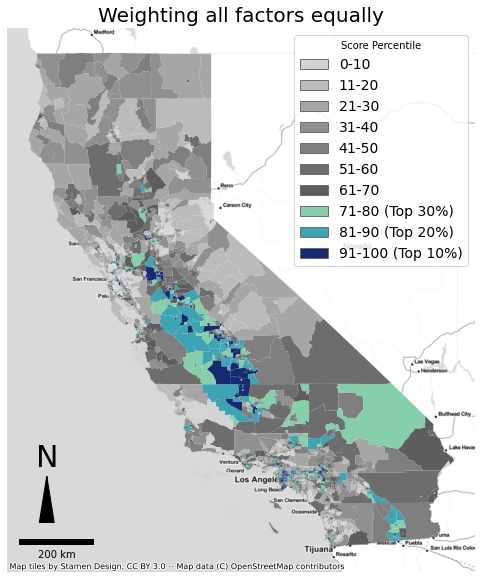

In [44]:
make_map(gdf, 'all_ces_score_pctl', title='Weighting all factors equally')

#### Mapping the differences in the top scoring tracts

In [45]:
def map_diff_tracts(gdf, ces_set, new_set, title="", path="", model="new model"):
    diff_new = list(new_set - ces_set)
    diff_ces = list(ces_set - new_set)
    in_both = list(ces_set.intersection(new_set))

    legend_elements = [
        Patch(facecolor='#acacac', edgecolor='#6d6d6d', label='Not in top 20%'),
        Patch(facecolor='#388186', edgecolor='#6d6d6d', label='In top 20% for both'),
        Patch(facecolor='#a5e9e1', edgecolor='#6d6d6d', label='In top 20% for CES4'),
        Patch(facecolor='#2e2b2b', edgecolor='#6d6d6d', label=f'In top 20% for {model}')
    ]

    fig, ax = plt.subplots(figsize=(10, 10))
    ax = gdf.to_crs(epsg=WEBMERC).plot(ax=ax, color="#acacac")
    ax = gdf[gdf['Tract'].isin(in_both)].to_crs(epsg=WEBMERC).plot(ax=ax, 
                                           color="#388186")
    ax = gdf[gdf['Tract'].isin(diff_ces)].to_crs(epsg=WEBMERC).plot(ax=ax, color="#a5e9e1") 
    ax = gdf[gdf['Tract'].isin(diff_new)].to_crs(epsg=WEBMERC).plot(ax=ax, 
                                           color="#2e2b2b")
    ax.text(x=-13800000-28000, y=4050000, s='N', fontsize=30)
    ax.arrow(-13800000, 3900000, 0, 200, length_includes_head=True,
             head_width=40000, head_length=500, overhang=250, facecolor='k')
    ax.add_artist(ScaleBar(location='lower left', box_alpha=0, dx=1, pad=1.1))
    ax.legend(handles=legend_elements,
                  loc='upper right',
                  fancybox=True, 
                  prop={'size': 14})
    ax.set_title(title, fontsize=20)
    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
    ax.axis('off')
    
    if (len(path) > 0):
        plt.savefig(path)
        
    plt.show()
    

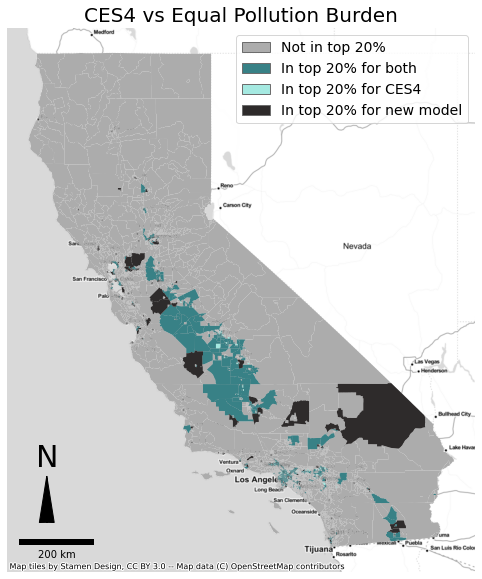

In [46]:
map_diff_tracts(gdf, ces_worst_tracts, eq_poll_burden_worst_tracts, 
                title = "CES4 vs Equal Pollution Burden")

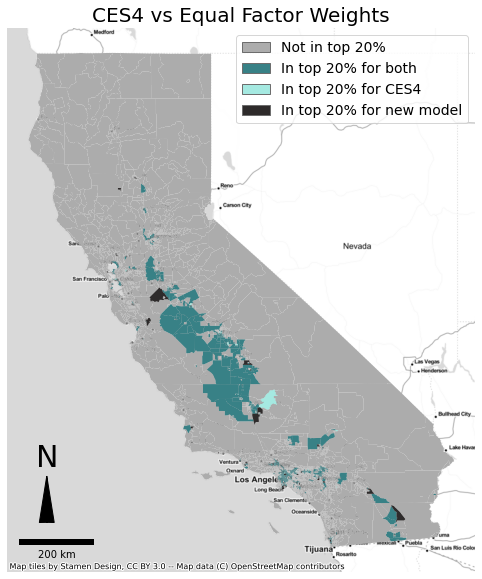

In [47]:
map_diff_tracts(gdf, ces_worst_tracts, all_ces_worst_tracts, 
                title = "CES4 vs Equal Factor Weights")

In [48]:
gdf['top_20_ces'] = np.where(gdf['ces_pctl'] > 80, 1, 0)
gdf['top_20_eq'] = np.where(gdf['eq_poll_burden_ces_score_pctl'] > 80, 1, 0)
gdf['top_20_all'] = np.where(gdf['all_ces_score_pctl'] > 80, 1, 0)

sig_tracts_count = gdf.groupby('county').sum()[['top_20_ces', 'top_20_eq', 'top_20_all']]
all_tracts_count = gdf.groupby('county').count()[['Tract']]

sig_tracts_prop = sig_tracts_count[['top_20_ces', 
                                    'top_20_eq', 
                                    'top_20_all']].div(all_tracts_count['Tract'], 
                                                       axis=0)

In [49]:
gdf = gdf.merge(sig_tracts_prop, on='county', suffixes=["", "_prop"])

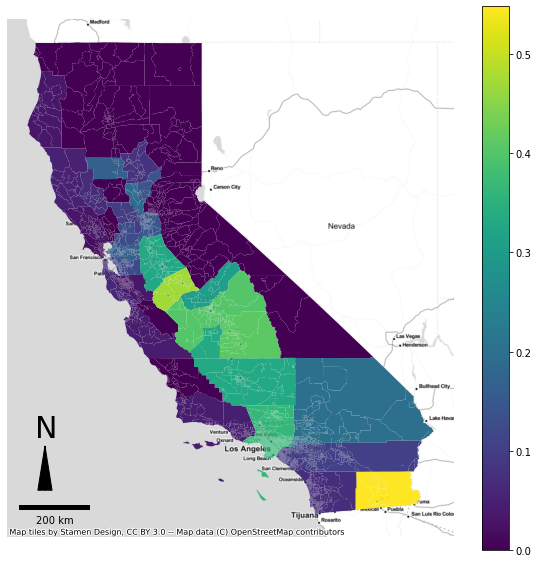

In [50]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = gdf.to_crs(epsg=WEBMERC).plot(column='top_20_eq_prop',
                                   ax=ax, legend=True)
ax.text(x=-13800000-28000, y=4050000, s='N', fontsize=30)
ax.arrow(-13800000, 3900000, 0, 200, length_includes_head=True,
         head_width=40000, head_length=500, overhang=250, facecolor='k')
ax.add_artist(ScaleBar(location='lower left', box_alpha=0, dx=1, pad=1.1))
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.axis('off')
        
plt.show()


## Exploratory analysis: Spatial Correlation Matrix

Here I propose that you can create a matrix that looks at the spatial relationship between two variables by looking at the Moran's I value for the difference between the percentiles (in effect, rank) between each of the variables. I will map out one example of this process first:

In [51]:
gdf_no_nan = gdf.dropna().copy()

In [52]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(gdf_no_nan, k=8)
# Row-standardization
w.transform = 'R'

/Users/vlingenfelter5/miniconda3/envs/ce263n/lib/python3.9/site-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])
/Users/vlingenfelter5/miniconda3/envs/ce263n/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [53]:
def moran_i_diff(col1, col2, w):
    diff = (col2 - col1) * 10 
    moran = esda.moran.Moran(diff, w)
    return moran.I

In [54]:
def moran_matrix_df(df, columns):
    # copy the data frame but remove NAN values (to get Moran I scores)
    df_no_nan = df.dropna().copy()
    
    # Generate W from the GeoDataFrame
    w = weights.distance.KNN.from_dataframe(df_no_nan, k=8)
    # Row-standardization
    w.transform = 'R'
    
    moran_dict = {k:{k2:-3 for k2 in columns} for k in columns}
    
    for col1 in columns:
        for col2 in columns:
            if (moran_dict[col1][col2] == -3):
                if (col1 == col2):
                    moran_dict[col1][col2] = 1
                    moran_dict[col2][col1] = 1
                else:
                    i = moran_i_diff(df_no_nan[col1+'_pctl'], df_no_nan[col2+'_pctl'], w)
                    moran_dict[col1][col2] = i
                    moran_dict[col2][col1] = i
                
    return pd.DataFrame.from_dict(moran_dict, orient='index')

This takes about 3 or so minutes to run on my computer. It's slow but I couldn't be bothered to figure out how to speed it up more than I already have.

In [55]:
morans = moran_matrix_df(gdf, factors_corr_matrix_columns)

/Users/vlingenfelter5/miniconda3/envs/ce263n/lib/python3.9/site-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])
/Users/vlingenfelter5/miniconda3/envs/ce263n/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [56]:
sig_locs = []
for i, col in enumerate(factors_corr_matrix_columns):
    sig_cols = morans[(morans[col] >= 0.75) & (morans[col] < 1)].index.tolist()
    
    if len(sig_cols)>0:
        for sig_col in sig_cols:
            sig_locs.append(((i+0.5), (factors_corr_matrix_columns.index(sig_col)+0.5)))

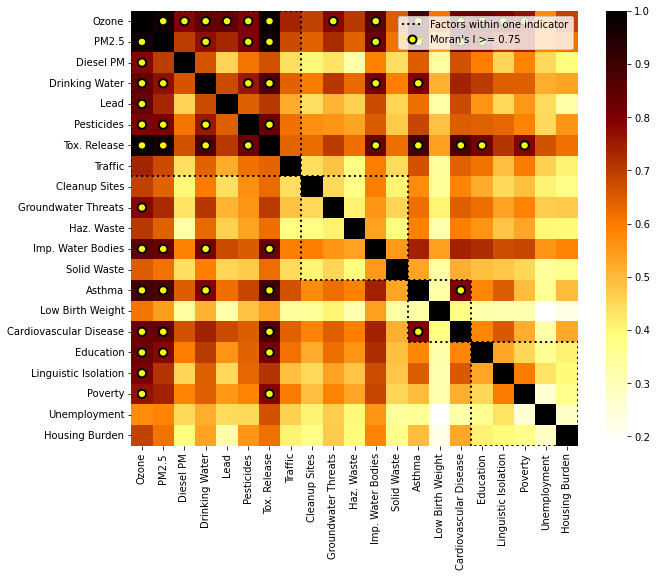

In [57]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(morans, cmap='afmhot_r', 
            xticklabels=[columns_readable_map[c] for c in morans.columns],
            yticklabels=[columns_readable_map[c] for c in morans.columns])

# add boxes around all the R values that are greater than 0.6 (by abs value)
for s in sig_locs:    
    # ax.add_patch(Rectangle(s, 1, 1, fill=False, edgecolor='k', lw=2))
    ax.add_patch(Circle(s, 0.2, facecolor='yellow', edgecolor='k', lw=2))

# add dashed lines around the different indicator groups
ax.add_patch(Rectangle((0,0), 8, 8, fill=False, edgecolor='k', lw=2, linestyle='dotted'))
ax.add_patch(Rectangle((8,8), 5, 5, fill=False, edgecolor='k', lw=2, linestyle='dotted'))
ax.add_patch(Rectangle((13,13), 3, 3, fill=False, edgecolor='k', lw=2, linestyle='dotted'))
ax.add_patch(Rectangle((16,16), 5, 5, fill=False, edgecolor='k', lw=2, linestyle='dotted'))

legend_elements = [
    Line2D([0], [0], color='k', lw=2, linestyle='dotted', 
           label='Factors within one indicator'),
    Line2D([0], [0], marker='o', color='yellow', label="Moran's I >= 0.75",
           markerfacecolor='yellow', markeredgecolor='k', 
           markeredgewidth=2, markersize=8),
]

ax.legend(handles=legend_elements,loc='upper right')